In [6]:
# Import necessary libraries
from src.models import RNNModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from os.path import dirname, join as pjoin
import torch
from torch import nn
import scipy.signal as signal

# Set data type and device
dtype = torch.float
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = torch.device("cpu")
print(device)
# Close all open plots
plt.close('all')

cpu


In [7]:
# Load data from file
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output_Q.mat')
data_out = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'W.mat')
W_data = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'in_week.mat')
week_data = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'in_weekend.mat')
weekend_data = scipy.io.loadmat(filepath)

# Extract data from dictionary
dExp, yExp, dExp_val, yExp_val, time__, yusers_array, yusers_val, time_separated, time_separated_val  = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__'], data_out['buildtotnorm'], data_out['buildtotnorm_val'],\
    data_out['time_separated'], data_out['time_separated_val']
W1, W2, b1, b2 = W_data['W1'], W_data['W2'], W_data['b1'], W_data['b2']
week, buil, Qout = week_data['input_NN_week_'], week_data['buildtot'], week_data['Qout_tot_']
weekend = weekend_data['input_NN_we_']


nExp = yExp.size


weekend = np.transpose(weekend)
print(weekend.shape)

(3, 240001)


Compute the FeedForward NN : testing MLP with 1 layer and 20 weights per layer (similar to the simulink)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

class FFmodel(nn.Module):
    
    def __init__(self, Ni, Nh, No):
        """
        Ni - Input size
           - Number of hidden layers is 1
        Nh - Neurons in the hidden layer
        No - Output size
        """
        super().__init__()
        
        self.W1 = nn.Parameter(torch.randn(Nh, Ni))#torch.from_numpy(W1).float()
        #self.W2 = nn.Parameter(torch.randn(Nh, Nh))
        self.W2 = nn.Parameter(torch.randn(No, Nh))#torch.from_numpy(W2).float()
        self.act = nn.Sigmoid() # activation function (sigmoid, relu, tanh)
        self.b1 = nn.Parameter(torch.randn(Nh, 1))#torch.from_numpy(b1).float()
        self.b2 = nn.Parameter(torch.randn(No, 1))#torch.from_numpy(b2).float()
        
    def forward(self, x):
        x = self.act(self.W1 @ x +self.b1)  #sigma(W1*x)     first hidden layer
        #x = self.act(self.W2 @ x) # sigma(W2*x)     second hidden layer
        x = self.W2 @ x +self.b2# output layer (no activation function)
        return x

In [4]:
# NN for the weekly data
ti = dExp[0 ,0].shape[0]  # Number of time steps

#initialize
d_users = torch.zeros(nExp*ti, 3)
y_users = torch.zeros(nExp*ti)

for j in range(nExp):
    d_users[j*ti:(j+1)*ti,:2] = torch.from_numpy(dExp[0, j][:, :-3]).squeeze()# only 2 first inputs
    d_users[j*ti:(j+1)*ti,2] = torch.from_numpy(time_separated[j*ti:(j+1)*ti,0]) #first column corresponds to the week
    y_users[j*ti:(j+1)*ti] = torch.from_numpy(yusers_array[j*ti:(j+1)*ti,0]) 

# Initialize the model, loss function, and optimizer
Ni = 3  # Number of input
Nh = 20
No = 1  # Number of output

model_week = FFmodel(Ni, Nh, No)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model_week.parameters(), lr=0.01)

# shape Qout_week if it is the week otherwise 0 
Qout_week = torch.zeros(int(len(Qout)/2))
max_Q = max(Qout[:int(len(Qout)/2)])
for i in range(int(len(week[0])/2)):
    if weekend[2,i] == 0: # corresponds to the weekend time
        Qout_week[i] = torch.from_numpy(Qout[i])/max_Q  # normalized output
# Load the model parameters before starting a new training session
#model_week.load_state_dict(torch.load('parameters_FFN_RNN_sep.pth'))

# Prepare the data (reshape for Conv1D)
# Assuming nExp is defined and you have filled d_users and y_users accordingly

d_users = d_users.transpose(0,1)  # (3, ti)


# Initialize array to store loss values
epochs = 15000
LOSS = np.zeros(epochs)
# Training loop (simple example)

for epoch in range(epochs):
    if epoch == epochs - epochs // 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(model_week.parameters(), lr=learning_rate)
    if epoch == epochs - epochs // 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(model_week.parameters(), lr=learning_rate)
    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    #outputs = model_week(d_users.float()).squeeze() # Ensure inputs are float
    outputs = model_week(torch.from_numpy(week[:,:int(len(week[0,:])/2)]).float()).squeeze()  # Ensure inputs are float
    # Create a mask where Qout_week is non-zero
    non_zero_mask = Qout_week != 0

    # Calculate loss only for non-zero elements in Qout_week by masking outputs and Qout_week
    loss = criterion(outputs[non_zero_mask], Qout_week[non_zero_mask])
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    LOSS[epoch] = loss.item()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Make predictions
with torch.no_grad():
    predictions = model_week(d_users.float())
    print("Predictions accuracy:", predictions-y_users.float())


Epoch [1/15000], Loss: 9.6697
Epoch [2/15000], Loss: 9.1109
Epoch [3/15000], Loss: 8.5513
Epoch [4/15000], Loss: 7.9819
Epoch [5/15000], Loss: 7.4091
Epoch [6/15000], Loss: 6.8101
Epoch [7/15000], Loss: 6.1923
Epoch [8/15000], Loss: 5.5925
Epoch [9/15000], Loss: 4.9694
Epoch [10/15000], Loss: 4.3104
Epoch [11/15000], Loss: 3.5204
Epoch [12/15000], Loss: 2.6720
Epoch [13/15000], Loss: 2.1699
Epoch [14/15000], Loss: 1.9478
Epoch [15/15000], Loss: 1.7824
Epoch [16/15000], Loss: 1.6317
Epoch [17/15000], Loss: 1.4914
Epoch [18/15000], Loss: 1.3616
Epoch [19/15000], Loss: 1.2418
Epoch [20/15000], Loss: 1.1311
Epoch [21/15000], Loss: 1.0297
Epoch [22/15000], Loss: 0.9372
Epoch [23/15000], Loss: 0.8519
Epoch [24/15000], Loss: 0.7738
Epoch [25/15000], Loss: 0.7018
Epoch [26/15000], Loss: 0.6340
Epoch [27/15000], Loss: 0.5710
Epoch [28/15000], Loss: 0.5176
Epoch [29/15000], Loss: 0.4681
Epoch [30/15000], Loss: 0.4197
Epoch [31/15000], Loss: 0.3770
Epoch [32/15000], Loss: 0.3399
Epoch [33/15000],

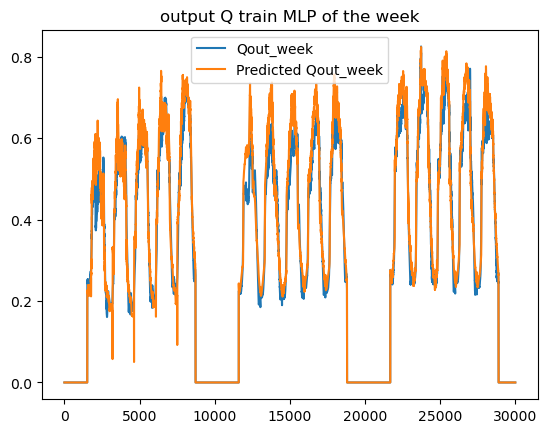

In [46]:
#plt.plot(week[:,:int(len(week[0,:])/2)])
outputs[~non_zero_mask]=0

plt.plot(Qout_week[:30000], label = 'Qout_week')
plt.plot(outputs[:30000].detach().numpy(), label = 'Predicted Qout_week')
plt.title("output Q train MLP of the week")
plt.legend()
plt.show()

In [8]:
# NN for the weekend data
ti = dExp[0 ,0].shape[0]  # Number of time steps

#initialize
d_users = torch.zeros(nExp*ti, 3)
y_users = torch.zeros(nExp*ti)

for j in range(nExp):
    d_users[j*ti:(j+1)*ti,:2] = torch.from_numpy(dExp[0, j][:, :-3]).squeeze()# only 2 first inputs
    d_users[j*ti:(j+1)*ti,2] = torch.from_numpy(time_separated[j*ti:(j+1)*ti,1]) #2nd column corresponds to the weekend
    y_users[j*ti:(j+1)*ti] = torch.from_numpy(yusers_array[j*ti:(j+1)*ti,0]) 

# Initialize the model, loss function, and optimizer
Ni = 3  # Number of input
Nh = 20
No = 1  # Number of output

model_weekend = FFmodel(Ni, Nh, No)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model_weekend.parameters(), lr=0.01)

# shape Qout_week if it is the week otherwise 0 
Qout_weekend = torch.zeros(int(len(Qout)/2))
max_Q = max(Qout[:int(len(Qout)/2)])
for i in range(int(len(weekend[0])/2)):
    if weekend[2,i] != 0: # corresponds to the weekend time
        Qout_weekend[i] = torch.from_numpy(Qout[i])/max_Q  # normalized output
# Load the model parameters before starting a new training session
#model_weekend.load_state_dict(torch.load('parameters_FFN_RNN_sep_weekend.pth'))

# Initialize array to store loss values
epochs = 15000
LOSS = np.zeros(epochs)
# Training loop (simple example)

for epoch in range(epochs):
    if epoch == epochs - epochs // 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(model_weekend.parameters(), lr=learning_rate)
    if epoch == epochs - epochs // 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(model_weekend.parameters(), lr=learning_rate)
    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    #outputs = model_week(d_users.float()).squeeze() # Ensure inputs are float
    outputs_WE = model_weekend(torch.from_numpy(weekend[:,:int(len(weekend[0,:])/2)]).float()).squeeze()  # Ensure inputs are float
    # Create a mask where Qout_week is non-zero
    non_zero_mask = Qout_weekend != 0
    # Calculate loss only for non-zero elements in Qout_week by masking outputs and Qout_week
    loss = criterion(outputs_WE[non_zero_mask], Qout_weekend[non_zero_mask])
    

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    LOSS[epoch] = loss.item()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


# Make predictions
#with torch.no_grad():
 #   predictions = model_weekend(d_users.float())
  #  print("Predictions accuracy:", predictions-y_users.float())


Epoch [1/15000], Loss: 12.9798
Epoch [2/15000], Loss: 11.9763
Epoch [3/15000], Loss: 10.9789
Epoch [4/15000], Loss: 9.9284
Epoch [5/15000], Loss: 8.8810
Epoch [6/15000], Loss: 7.7608
Epoch [7/15000], Loss: 6.2800
Epoch [8/15000], Loss: 5.0039
Epoch [9/15000], Loss: 2.0149
Epoch [10/15000], Loss: 0.3407
Epoch [11/15000], Loss: 0.2909
Epoch [12/15000], Loss: 0.2662
Epoch [13/15000], Loss: 0.2555
Epoch [14/15000], Loss: 0.2557
Epoch [15/15000], Loss: 0.2635
Epoch [16/15000], Loss: 0.2762
Epoch [17/15000], Loss: 0.2911
Epoch [18/15000], Loss: 0.3058
Epoch [19/15000], Loss: 0.3195
Epoch [20/15000], Loss: 0.3309
Epoch [21/15000], Loss: 0.3391
Epoch [22/15000], Loss: 0.3443
Epoch [23/15000], Loss: 0.3458
Epoch [24/15000], Loss: 0.3435
Epoch [25/15000], Loss: 0.3373
Epoch [26/15000], Loss: 0.3275
Epoch [27/15000], Loss: 0.3148
Epoch [28/15000], Loss: 0.2995
Epoch [29/15000], Loss: 0.2817
Epoch [30/15000], Loss: 0.2619
Epoch [31/15000], Loss: 0.2411
Epoch [32/15000], Loss: 0.2201
Epoch [33/1500

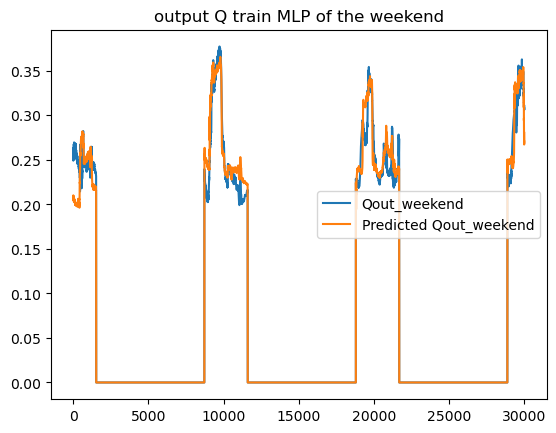

In [9]:
outputs_WE[~non_zero_mask]=0

plt.plot(Qout_weekend[:30000], label = 'Qout_weekend')
plt.plot(outputs_WE[:30000].detach().numpy(), label = 'Predicted Qout_weekend')
plt.title("output Q train MLP of the weekend")
plt.legend()
plt.show()

In [11]:
Predictions = model_week(torch.from_numpy(week[:,:int(len(week[0,:])/2)]).float()) + model_weekend(torch.from_numpy(weekend[:,:int(len(weekend[0,:])/2)]).float())

plt.plot(Qout[:30000], label = 'Qout')
plt.plot(Predictions[:30000].detach().numpy(), label = 'Predicted Qout_weekend')
plt.title("output Q train MLP of the weekend")
plt.legend()
plt.show()

KeyboardInterrupt: 

In [ ]:
#VALIODATION FOR WEEKEND
#initialize
d_users_val = torch.zeros(ti, 3)
y_users_val = torch.zeros(ti)

d_users_val[:, :2] = torch.from_numpy(dExp_val[0, 0][:, :-3]).squeeze()
d_users_val[:, 2] = torch.from_numpy(time_separated_val[:, 0]) #week column1
y_users_val[:] = torch.from_numpy(yusers_val[:,0]) 

# Get CNN output for validation data
# Prepare the data (reshape for Conv1D)
# Assuming nExp is defined and you have filled d_users and y_users accordingly
d_users_val = d_users_val.view(-1, 3, ti)  # Shape: (nExp, 3, ti)
y_users_val = y_users_val.view(-1, ti)      # Shape: (nExp, ti)
y_val = model_weekend(d_users_val).squeeze(0)

# Calculate loss for validation data
loss_val = criterion(y_val, y_users_val)
print('Validation loss: ', loss_val.item())

[[ 982.90791589]
 [ 981.08584311]
 [1002.43095478]
 ...
 [ 707.24283933]
 [ 838.92974822]
 [ 714.15904156]]
[[ 892.00252965]
 [ 883.96205898]
 [ 884.85563964]
 ...
 [1300.9145346 ]
 [1301.50879005]
 [1302.09821238]]


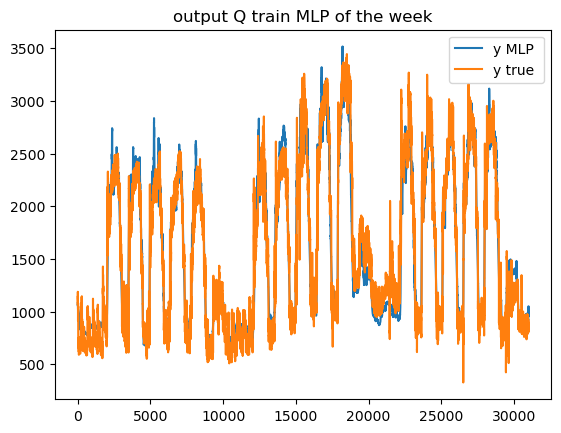

In [ ]:
# Plot output Q for validation data
print(buil)
print(Qout)
plt.figure('2')
#plt.plot(y_val[0, 0, :], label='MLP val')
plt.plot(Qout[30000:61000], label='y MLP ')
plt.plot(buil[30000:61000], label='y true')

plt.title("output Q train MLP of the week")
plt.legend()
plt.show()

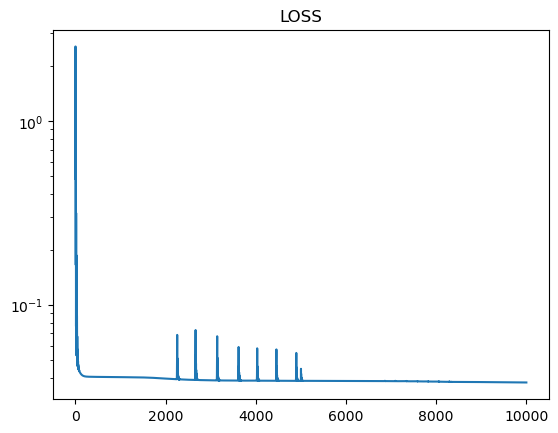

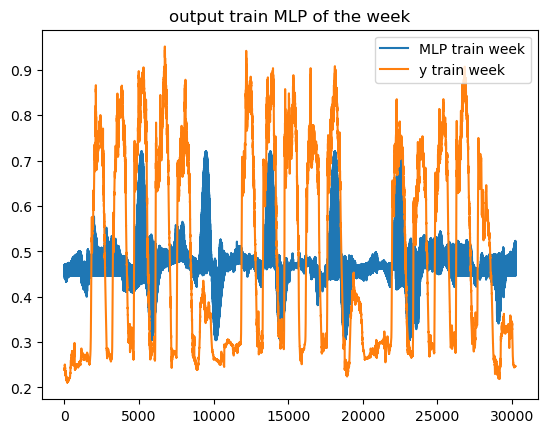

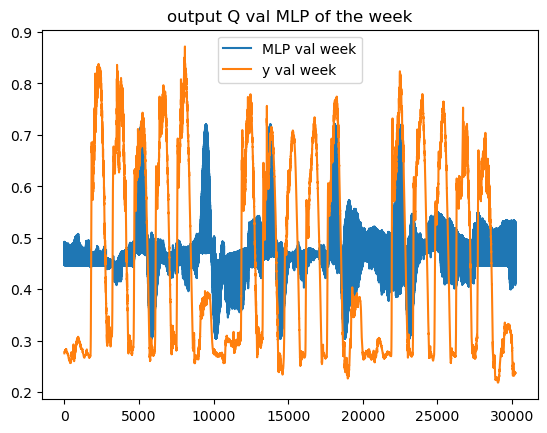

In [ ]:
# PLOTS FOR WEEK
# Plot loss over epochs
plt.figure('8')
plt.plot(LOSS)
plt.yscale('log')
plt.title("LOSS")
plt.show()

# Plot output Q for training data
plt.figure('1')
plt.plot(predictions[0,0, 10:].detach().numpy(), label='MLP train week')
plt.plot(y_users[0, 10:].detach().numpy(), label='y train week')
plt.title("output train MLP of the week")
plt.legend()
plt.show()

# Plot output Q for validation data
plt.figure('2')
#plt.plot(y_val[0, 0, :], label='MLP val')
plt.plot(y_val[0, 0, 10:].detach().numpy(), label='MLP val week')
plt.plot(y_users_val[0, 10:].detach().numpy(), label='y val week')
plt.title("output Q val MLP of the week")
plt.legend()
plt.show()

In [ ]:
# Save the model parameters after training
torch.save(model_week.state_dict(), 'parameters_FFN_RNN_sep.pth')

In [ ]:
# PLOTS FOR WEEKEND
# PLOTS FOR WEEK
# Plot loss over epochs
plt.figure('8')
plt.plot(LOSS)
plt.yscale('log')
plt.title("LOSS")
plt.show()

# Plot output Q for training data
plt.figure('1')
plt.plot(predictions[0,0, 10:].detach().numpy(), label='MLP train weekend')
plt.plot(y_users[0, 10:].detach().numpy(), label='y train weekend')
plt.title("output train MLP for the weekend")
plt.legend()
plt.show()

# Plot output Q for validation data
plt.figure('2')
plt.plot(y_val[0, 10:].detach().numpy(), label='MLP val weekend')
plt.plot(y_users_val[0, 10:].detach().numpy(), label='y val weekend')
plt.title("output Q val MLP for the weekend")
plt.legend()
plt.show()

# Save the model parameters after training
torch.save(model_week.state_dict(), 'parameters_FFN_RNN_sep_weekend.pth')

In [ ]:
#TRY WITHOUT TIME AS INPUT...

# NN for the weekly data
ti = dExp[0 ,0].shape[0]  # Number of time steps

#initialize
d_users = torch.zeros(nExp*ti, 2)
y_users = torch.zeros(nExp*ti)

for j in range(nExp):
    d_users[j*ti:(j+1)*ti,:2] = torch.from_numpy(dExp[0, j][:, :-3]).squeeze()# only 2 first inputs
    y_users[j*ti:(j+1)*ti] = torch.from_numpy(yusers_array[j*ti:(j+1)*ti,0]) 

# Initialize the model, loss function, and optimizer
Ni = 2  # Number of input
Nh = 20
No = 1  # Number of output

model = FFmodel(Ni, Nh, No)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load the model parameters before starting a new training session
#model.load_state_dict(torch.load('parameters_FFN_RNN_notime.pth'))

# Prepare the data (reshape for Conv1D)
# Assuming nExp is defined and you have filled d_users and y_users accordingly
d_users = d_users.view(-1, 2, ti)  # Shape: (nExp, 3, ti)
y_users = y_users.view(-1, ti)      # Shape: (nExp, ti)

# Training loop (simple example)
num_epochs = 5000
for epoch in range(num_epochs):
    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(d_users.float())  # Ensure inputs are float
    loss = criterion(outputs, y_users.float())  # Compute loss

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions
with torch.no_grad():
    predictions = model(d_users.float())
    print("Predictions accuracy:", predictions-y_users.float())



In [ ]:
#initialize
d_users_val = torch.zeros(ti, 2)
y_users_val = torch.zeros(ti)

d_users_val[:, :2] = torch.from_numpy(dExp_val[0, 0][:, :-3]).squeeze()
y_users_val[:] = torch.from_numpy(yusers_val[:,0]) 

# Get CNN output for validation data
# Prepare the data (reshape for Conv1D)
# Assuming nExp is defined and you have filled d_users and y_users accordingly
d_users_val = d_users_val.view(-1, 2, ti)  # Shape: (nExp, 2, ti)
y_users_val = y_users_val.view(-1, ti)      # Shape: (nExp, ti)
y_val = model(d_users_val)

# Calculate loss for validation data
loss_val = criterion(y_val, y_users_val)
print('Validation loss: ', loss_val.item())

# Plot output Q for training data
plt.figure('1')
plt.plot(predictions[0,0, :].detach().numpy(), label='MLP train')
plt.plot(y_users[0, :].detach().numpy(), label='y train')
plt.title("output train MLP")
plt.legend()
plt.show()

# Plot output Q for validation data
plt.figure('2')
plt.plot(y_val[0, 0, :].detach().numpy(), label='MLP val')
plt.plot(y_users_val[0, :].detach().numpy(), label='y val')
plt.title("output Q val MLP")
plt.legend()
plt.show()

In [ ]:
# Save the model parameters after training
torch.save(model.state_dict(), 'parameters_FFN_RNN_notime.pth')

In [ ]:
# Create time vector
#t = np.arange(0, np.size(dExp[0, 0], 1) * Ts, Ts)
t = time__

# Set end time
t_end = t.size

# Initialize input and output tensors
input_size = 3
u = torch.zeros(nExp, t_end, input_size)
y = torch.zeros(nExp, t_end, 2)

# Set input number
inputnumberD = input_size-1

# Fill input and output tensors with data
for j in range(nExp):
    u[j, :, :] = torch.cat(
        (torch.from_numpy(dExp[0, j][:, 3:]),    # Take columns 3 onwards from dExp
        predictions[j, 0, :].unsqueeze(1)),     # Add extra dimension to predictions using unsqueeze(1)
        dim=-1
        )       
    y[j, :, :] = (torch.from_numpy(yExp[0, j]))
    
    #u[j, :, 4] = torch.from_numpy(signal.medfilt((u[j, :, 4]).numpy(), 13))

# Set random seed for reproducibility
seed = 1
torch.manual_seed(seed)

In [ ]:
#Set dimensions for RNN layers
idd = input_size
hdd = 10
ldd = 2
odd = yExp[0, 0].shape[1]

# Initialize RNN model
RNN = RNNModel(idd, hdd, ldd, odd)

# Load the model parameters before starting a new training session
RNN.load_state_dict(torch.load('parameters_RNN_with_FFN.pth'))

# Define loss function
MSE = nn.MSELoss()

# Define optimization method
learning_rate = 1.0e-2
optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Set number of epochs
epochs = 50

# Initialize array to store loss values
LOSS = np.zeros(epochs)


In [ ]:
# Train the RNN model
for epoch in range(epochs):
    # Adjust learning rate at certain epochs
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0

    # Get RNN output for training data
    yRNN = RNN(u)
    yRNN = torch.squeeze(yRNN)
    

    # Calculate loss and backpropagate
    loss = MSE(yRNN, y)
    loss.backward()
    optimizer.step()
    

    # Print loss for current epoch
    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    LOSS[epoch] = loss
    
    # Save model parameters every 15 epochs
    if (epoch + 1) % 15 == 0:
        torch.save(RNN.state_dict(), f'parameters_RNN_with_FFN.pth')
        print(f"Model parameters saved at epoch {epoch + 1}")

In [ ]:
# Initialize input and output tensors for validation data
nExp = yExp_val.size
uval = torch.zeros(nExp, t_end, input_size)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    inputActive = (torch.from_numpy(dExp_val[0, j]))#[:,:-1]))
    uval[j, :, :] = torch.unsqueeze(inputActive[:,inputnumberD], 1)
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))
    #uval[j, :, 4] = torch.from_numpy(signal.medfilt((uval[j, :, 4]).numpy(), 25))

# Get RNN output for validation data
yRNN_val = RNN(uval)
yRNN_val = yRNN_val.unsqueeze_(0)

# Calculate loss for validation data
loss_val = MSE(yRNN_val, yval)

In [ ]:
# Plot loss over epochs
plt.figure('8')
plt.plot(LOSS)
plt.title("LOSS")
plt.show()

# Plot output 1 for training data
plt.figure('9')
plt.plot(yRNN[0, :, 0].detach().numpy(), label='RNN')
plt.plot(y[0, :, 0].detach().numpy(), label='y train')
plt.title("output 1 train single RNN")
plt.legend()
plt.show()

# Plot output 1 for validation data
plt.figure('10')
plt.plot(yRNN_val[0, :, 0].detach().numpy(), label='RNN val')
plt.plot(yval[0, :, 0].detach().numpy(), label='y val')
plt.title("output 1 val single RNN")
plt.legend()
plt.show()

# Plot output 2 for training data
plt.figure('11')
plt.plot(yRNN[0, :, 1].detach().numpy(), label='RNN')
plt.plot(y[0, :, 1].detach().numpy(), label='y train')
plt.title("output 2 train single RNN")
plt.legend()
plt.show()

# Plot output 2 for validation data
plt.figure('12')
plt.plot(yRNN_val[0, :, 1].detach().numpy(), label='RNN val')
plt.plot(yval[0, :, 1].detach().numpy(), label='y val')
plt.title("output 2 val single RNN")
plt.legend()
plt.show()

# Save RNN output and validation data to file
scipy.io.savemat('data_singleRNN_sysID.mat', dict(yRENm_val=yRNN_val.detach().numpy(), yval=yval.detach().numpy()))

# Print validation loss
print(f"Loss Validation single RNN: {loss_val}")

In [ ]:
0.0052    / 0.0037  / 0.003